# Modelos de regresión lineal, con regularización y regresión polinómica con regularización

Para saltar a la conclusión y evitar la parte técnica, ver directamente el apartado final **4. Resumen y Conclusiones**


# 0. Preprocessing

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import math

/opt/conda/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#General inputs

#csv file from Enverus
#input_path = 'C:/Users/r110195/OneDrive - Repsol/Work/Eagle Ford/Benchmarking IHS/Enverus_PBI/Wells/env_csv-Wells-93e91_2023-12-12.csv'
input_path = 'env_csv-Wells-93e91_2023-12-12.csv'

#folder to receive outputs
output_folder='.'


In [3]:
#read public data

#variable names
well_spacing_ft='AvgHzDistAtDrillTime100dVZone_FT'
sand_loading_ppf='ProppantIntensity_LBSPerFT'
water_loading_bpf='FluidIntensity_BBLPerFT'
SLL_ft='LateralLength_FT'
parent_child_raw='ENVSpacingClass_Vertical100AtInitialClass'
oil_qi_BPDper1000ft='PeakOil_BBLPer1000FT'
oil_b_factor='OilBFactor'
oil_decline_rate='OilInitialDecline'
gas_qi_MCFPDper1000ft='PeakGas_MCFPer1000FT'
gas_b_factor='GasBFactor'
gas_decline_rate='GasInitialDecline'
cum_BOE_1Y_BOEper1000ft = 'First12MonthProd_BOEPer1000FT'

#list of columns to import
import_columns=[ \
    'API_UWI_14', \
    'County', \
    'Vintage', \
    well_spacing_ft, \
    sand_loading_ppf, \
    water_loading_bpf, \
    parent_child_raw, \
    SLL_ft, \
    'GOR_ScfPerBbl', \
    cum_BOE_1Y_BOEper1000ft, \
    oil_qi_BPDper1000ft, \
    oil_b_factor, \
    oil_decline_rate, \
    gas_qi_MCFPDper1000ft, \
    gas_b_factor, \
    gas_decline_rate]

wells_DF=pd.read_csv(input_path,usecols=import_columns)
print('complete dataset size: ' + str(wells_DF.shape))

#clean lines with an empty values
wells_DF=wells_DF.dropna()
print('after dropna() dataset size: ' + str(wells_DF.shape))

#filter for sand loading min/max
wells_DF=wells_DF[wells_DF[sand_loading_ppf]>500]
wells_DF=wells_DF[wells_DF[sand_loading_ppf]<4000]
#filter for water loading min/max
wells_DF=wells_DF[wells_DF[water_loading_bpf]>10]
wells_DF=wells_DF[wells_DF[water_loading_bpf]<100]
#filter for well sapcing min/max
wells_DF=wells_DF[wells_DF[well_spacing_ft]>100]
wells_DF=wells_DF[wells_DF[well_spacing_ft]<2000]
#filter for cum BOE min/max
#wells_DF=wells_DF[wells_DF[cum_BOE_1Y_BOEper1000ft]<100000]
print('after sand loading / well spacing filtering dataset size: ' + str(wells_DF.shape))

#calculate peak rate per day
wells_DF[gas_qi_MCFPDper1000ft]=wells_DF[gas_qi_MCFPDper1000ft] / 30.5
wells_DF[oil_qi_BPDper1000ft]=wells_DF[oil_qi_BPDper1000ft] / 30.5

#re-order index
wells_DF=wells_DF.reset_index(drop=True)
print('pre-processed dataset size: ' + str(wells_DF.shape))

complete dataset size: (33115, 16)
after dropna() dataset size: (19839, 16)
after sand loading / well spacing filtering dataset size: (18704, 16)
pre-processed dataset size: (18704, 16)


Reemplazar for por funcion apply para codificar tipo de fluido en la columna Reservoir_Fluid

In [4]:
#create a reservoir fluid index

wells_DF['CGR_stb_per_MMscf'] = 1/wells_DF['GOR_ScfPerBbl']*1000000

# wells_DF['Reservoir_Fluid'] = 'Undefined'
# for n in range(0,len(wells_DF.index)):
#     cgr = wells_DF['CGR_stb_per_MMscf'][n]
#     if cgr<10:
#         wells_DF['Reservoir_Fluid'][n] = '0_Dry gas'
#     elif cgr<67:
#         wells_DF['Reservoir_Fluid'][n] = '1_Wet gas'
#     elif cgr<313:
#         wells_DF['Reservoir_Fluid'][n] = '2_Retrograde gas'
#     elif cgr<569:
#         wells_DF['Reservoir_Fluid'][n] = '3_Volatile oil'
#     else:
#         wells_DF['Reservoir_Fluid'][n] = '4_Black oil'

def get_reservoir_fluid(cgr):
    if cgr<10:
        return '0_Dry gas'
    elif cgr<67:
        return '1_Wet gas'
    elif cgr<313:
        return '2_Retrograde gas'
    elif cgr<569:
        return '3_Volatile oil'
    else:
        return '4_Black oil'

wells_DF['Reservoir_Fluid'] = wells_DF["CGR_stb_per_MMscf"].apply(lambda x: get_reservoir_fluid(x))        
        
wells_DF.Reservoir_Fluid.value_counts()

Reservoir_Fluid
4_Black oil         7593
2_Retrograde gas    5390
3_Volatile oil      4127
1_Wet gas           1285
0_Dry gas            309
Name: count, dtype: int64

In [5]:
wells_DF.head(2)

,API_UWI_14,County,Vintage,LateralLength_FT,ProppantIntensity_LBSPerFT,FluidIntensity_BBLPerFT,First12MonthProd_BOEPer1000FT,PeakGas_MCFPer1000FT,PeakOil_BBLPer1000FT,GOR_ScfPerBbl,AvgHzDistAtDrillTime100dVZone_FT,GasBFactor,GasInitialDecline,OilBFactor,OilInitialDecline,ENVSpacingClass_Vertical100AtInitialClass,CGR_stb_per_MMscf,Reservoir_Fluid
0,42-123-33209-00-00,DEWITT,2014.0,4359.0,2828.0,50.0,53533.0,341.081967,176.426230,2347.0,471.0,0.75,0.17,0.77,0.22,CO | CO,426.075841,3_Volatile oil
1,42-127-36477-00-00,DIMMIT,2015.0,5161.0,2130.0,32.0,14602.0,285.540984,41.639344,7797.0,564.0,0.85,0.17,1.20,0.24,C | CO,128.254457,2_Retrograde gas


Reemplazar for por funcion apply para codificar Parent o Child

In [6]:
#create parent-child flag (as per Enverus definition)
parent_list = ['P |','P | P','CO |','CO | CO','P | CO']

#wells_DF['Parent_Child'] = 'Child'

#for n in range(0,len(wells_DF.index)):
#    tmp_flag=wells_DF[parent_child_raw][n]
#    if tmp_flag in parent_list:
#        wells_DF['Parent_Child'][n]='Parent'

wells_DF['Parent_Child'] = wells_DF[parent_child_raw].apply(
    lambda x: 'Parent' if x in parent_list else 'Child')

In [7]:
len(wells_DF)

18704

Reemplazar for por funcion apply para codificar Area

In [8]:
#create a flag for Repsol areas
#West = DIMMIT, LA SALLE
#Central = ATASCOSA, MCMULLEN, LIVE OAK
#East = BEE, KARNES, DEWITT, WILSON

west_area_list=['DIMMIT', 'LA SALLE']
central_area_list=['ATASCOSA', 'MCMULLEN', 'LIVE OAK']
east_area_list=['BEE', 'KARNES', 'DEWITT', 'WILSON']

# wells_DF['Area'] = 'Undef'
# for n in range(0,len(wells_DF.index)):
#     tmp_county=wells_DF['County'][n]
#     if tmp_county in west_area_list:
#         wells_DF['Area'][n]='West'
#     elif tmp_county in central_area_list:
#         wells_DF['Area'][n]='Central'
#     elif tmp_county in east_area_list:
#         wells_DF['Area'][n]='East'

def label_area(tmp_county):
    
    if tmp_county in west_area_list:
        return 'West'
    elif tmp_county in central_area_list:
        return 'Central'
    elif tmp_county in east_area_list:
        return 'East'
    return 'Undef'
    
wells_DF['Area'] = wells_DF['County'].apply(lambda x: label_area(x))

In [9]:
#restrict for easier calcs
wells_DF=wells_DF[wells_DF['County'].isin(['DIMMIT','LA SALLE','MCMULLEN','ATASCOSA','LIVE OAK','BEE','KARNES','DEWITT','WILSON'])]
#wells_DF = wells_DF[wells_DF["Reservoir_Fluid"].isin(["2_Retrograde gas","1_Wet gas"])]
wells_DF = wells_DF[wells_DF["Vintage"]>=2015]
wells_DF = wells_DF[wells_DF["CGR_stb_per_MMscf"]<2500]
print('selected dataset size: ' + str(wells_DF.shape))

#export selected dataset of public data
#wells_DF.reindex(columns=import_columns)
#wells_DF_export=wells_DF[import_columns]
#wells_DF_export.to_csv(output_folder+'/headers/public_data_headers.csv',index=False)

selected dataset size: (8350, 20)


In [10]:
#export public data header to csv
wells_DF_export=wells_DF.copy()

#rename columns
wells_DF_export.rename(columns={well_spacing_ft:'Well Spacing (ft)'},inplace=True)
wells_DF_export.rename(columns={sand_loading_ppf:'Sand Loading (lbs/ft)'},inplace=True)
wells_DF_export.rename(columns={water_loading_bpf:'Water Loading (bbls/ft)'},inplace=True)
wells_DF_export.rename(columns={SLL_ft:'lateral Length (ft)'},inplace=True)
wells_DF_export.rename(columns={cum_BOE_1Y_BOEper1000ft:'Norm Cum BOE 1Y (BOE/1000ft)'},inplace=True)
wells_DF_export.rename(columns={oil_qi_BPDper1000ft:'Oil Qi (stb/d/1000ft)'},inplace=True)
wells_DF_export.rename(columns={oil_b_factor:'Oil B Factor'},inplace=True)
wells_DF_export.rename(columns={oil_decline_rate:'Oil Initial Decline Rate (% Monthly)'},inplace=True)
wells_DF_export.rename(columns={gas_qi_MCFPDper1000ft:'Gas Qi (Mscf/d/1000ft)'},inplace=True)
wells_DF_export.rename(columns={gas_b_factor:'Gas B Factor'},inplace=True)
wells_DF_export.rename(columns={gas_decline_rate:'Gas Initial Decline Rate (% Monthly)'},inplace=True)

#drop columns not to be used
export_columns=['API_UWI_14','County','Vintage','Area','CGR_stb_per_MMscf','Sand Loading (lbs/ft)','Water Loading (bbls/ft)','lateral Length (ft)','GOR_ScfPerBbl','Norm Cum BOE 1Y (BOE/1000ft)','Well Spacing (ft)','Parent_Child','Oil Qi (stb/d/1000ft)','Oil B Factor','Oil Initial Decline Rate (% Monthly)','Gas Qi (Mscf/d/1000ft)','Gas B Factor','Gas Initial Decline Rate (% Monthly)']
wells_DF_export=wells_DF_export[export_columns]

print(wells_DF_export.columns)
wells_DF_export.to_csv('public_data_headers.csv',index=False)

Index(['API_UWI_14', 'County', 'Vintage', 'Area', 'CGR_stb_per_MMscf',
       'Sand Loading (lbs/ft)', 'Water Loading (bbls/ft)',
       'lateral Length (ft)', 'GOR_ScfPerBbl', 'Norm Cum BOE 1Y (BOE/1000ft)',
       'Well Spacing (ft)', 'Parent_Child', 'Oil Qi (stb/d/1000ft)',
       'Oil B Factor', 'Oil Initial Decline Rate (% Monthly)',
       'Gas Qi (Mscf/d/1000ft)', 'Gas B Factor',
       'Gas Initial Decline Rate (% Monthly)'],
      dtype='object')


In [11]:
wells_DF['County'] = wells_DF['County'].astype('category')
wells_DF['Vintage'] = wells_DF['Vintage'].astype('category')
wells_DF['Reservoir_Fluid'] = wells_DF['Reservoir_Fluid'].astype('category')
wells_DF[parent_child_raw] = wells_DF[parent_child_raw].astype('category')
wells_DF['Parent_Child'] = wells_DF['Parent_Child'].astype('category')
wells_DF['Area'] = wells_DF['Area'].astype('category')
#wells_DF['API_UWI_14'] = wells_DF['API_UWI_14'].astype('category')
#wells_DF.dtypes
wells_DF.describe().T

,count,mean,std,min,25%,50%,75%,max
LateralLength_FT,8350.0,6716.830778,2249.527246,1514.000000,5173.250000,6229.000000,7815.250000,16883.000000
ProppantIntensity_LBSPerFT,8350.0,2036.478323,660.776882,511.000000,1536.250000,2010.000000,2508.000000,3997.000000
FluidIntensity_BBLPerFT,8350.0,39.282754,14.192563,11.000000,28.000000,39.000000,49.000000,98.000000
First12MonthProd_BOEPer1000FT,8350.0,29057.721916,19896.468628,160.000000,15573.750000,22845.500000,37759.000000,268422.000000
PeakGas_MCFPer1000FT,8350.0,296.988507,327.177677,6.557377,87.409836,180.803279,377.811475,3461.377049
PeakOil_BBLPer1000FT,8350.0,122.093657,91.217399,0.032787,62.655738,97.836066,155.934426,1114.000000
GOR_ScfPerBbl,8350.0,8755.828862,64409.560893,401.000000,1406.000000,2371.000000,4521.750000,1000000.000000
AvgHzDistAtDrillTime100dVZone_FT,8350.0,521.478683,298.122637,105.000000,328.000000,426.000000,619.750000,1997.000000
GasBFactor,8350.0,0.959920,0.157348,0.600000,0.850000,0.900000,1.100000,1.500000
GasInitialDecline,8350.0,0.357618,0.379458,0.040000,0.130000,0.240000,0.460000,11.300000


<Figure size 1080x576 with 0 Axes>

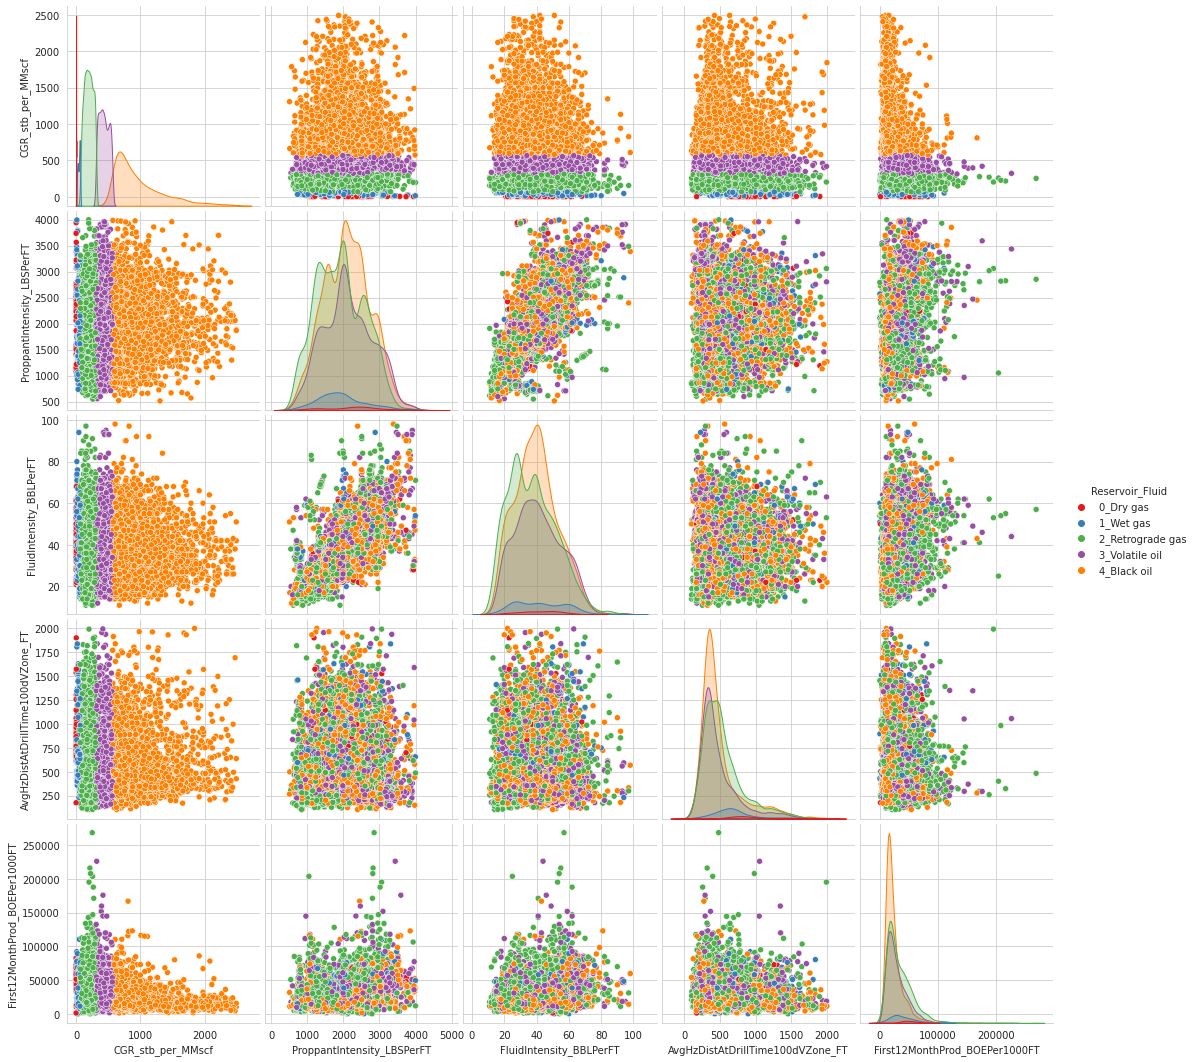

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
sns.pairplot(
    wells_DF[["Reservoir_Fluid","CGR_stb_per_MMscf","Parent_Child","ProppantIntensity_LBSPerFT",'FluidIntensity_BBLPerFT', "AvgHzDistAtDrillTime100dVZone_FT","First12MonthProd_BOEPer1000FT"]],
    hue = "Reservoir_Fluid",
    height = 3,
    palette = "Set1")
plt.show()

**Estandarizacion y escalado de datos**  

El scaler se utiliza solo viendo datos de training. No es correcto utilizar los datos de test para hacer el fit y el transform. Se debería hacer el fit con el training y posteriormente el transform con los datos de test. Esto se conoce como "data leakage" del tipo "train-test contamination" que basicamente es utilizar informacion de los datos del test que queda reflejada en los datos del training.

https://www.kaggle.com/code/alexisbcook/data-leakage

In [13]:
#create variables for regression
model_DF = wells_DF[['Area', \
                    'CGR_stb_per_MMscf', \
                     sand_loading_ppf, \
                     water_loading_bpf, \
                     well_spacing_ft, \
                     'Parent_Child', \
                     oil_qi_BPDper1000ft, \
                     oil_b_factor, \
                     oil_decline_rate, \
                     gas_qi_MCFPDper1000ft, \
                     gas_b_factor, \
                     gas_decline_rate]]
print('model dataset size: ' + str(model_DF.shape))

#use log for CGR to center the distribution
model_DF['CGR_stb_per_MMscf']=np.log(model_DF['CGR_stb_per_MMscf'])

#create One Hot Encoding
model_DF_One_Hot_Encoding = pd.get_dummies(model_DF)
print('One Hot Encoding model dataset size: ' + str(model_DF_One_Hot_Encoding.shape))

#create variable and test-train dataset
dca_parameters = [ oil_qi_BPDper1000ft,\
                              oil_b_factor, \
                              oil_decline_rate, \
                              gas_qi_MCFPDper1000ft, \
                              gas_b_factor, \
                              gas_decline_rate]

model dataset size: (8350, 12)
One Hot Encoding model dataset size: (8350, 15)


<ipython-input-13-26ca7d497f5b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_DF['CGR_stb_per_MMscf']=np.log(model_DF['CGR_stb_per_MMscf'])


In [15]:
model_DF_One_Hot_Encoding

,CGR_stb_per_MMscf,ProppantIntensity_LBSPerFT,FluidIntensity_BBLPerFT,AvgHzDistAtDrillTime100dVZone_FT,PeakOil_BBLPer1000FT,OilBFactor,OilInitialDecline,PeakGas_MCFPer1000FT,GasBFactor,GasInitialDecline,Area_Central,Area_East,Area_West,Parent_Child_Child,Parent_Child_Parent
1,4.854016,2130.0,32.0,564.0,41.639344,1.20,0.24,285.540984,0.85,0.17,False,False,True,True,False
2,4.992746,636.0,15.0,466.0,25.672131,0.94,0.56,74.590164,0.92,0.20,False,False,True,False,True
3,4.914689,1200.0,24.0,305.0,253.803279,0.80,0.75,1499.639344,1.04,0.89,False,True,False,False,True
4,6.092390,1190.0,19.0,496.0,51.672131,1.15,0.69,92.688525,0.86,0.33,False,False,True,True,False
6,6.466280,1500.0,22.0,751.0,64.098361,0.80,0.19,80.950820,1.20,0.15,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18698,5.096683,1726.0,29.0,1011.0,41.213115,0.80,0.18,201.868852,0.85,0.10,False,False,True,False,True
18699,6.070941,3289.0,50.0,400.0,203.606557,0.97,0.46,256.000000,1.20,0.18,False,True,False,False,True
18700,5.576709,2957.0,53.0,718.0,262.655738,0.80,0.41,536.262295,0.75,0.12,False,True,False,True,False
18701,3.391148,2013.0,62.0,464.0,36.491803,1.20,0.36,946.459016,0.70,0.15,False,True,False,False,True


**TBD : Check values to delete posible outliers**

Es importante que las variables explicativas del dataset tengan sus rangos lo mas parecido a los datos en los cuales se piensa aplicar el modelo. Los modelos pueden ser muy sensibles a outliers, es decir, agregando o eliminando solo un par de observaciones con variables en un rango extremo, el modelo puede variar mucho la magnitud de las predicciones. Esto logicamente subestima la performance del modelo en las métricas de entrenamiento.  

Filter Dataset based on:  
- PeakOil_BBLper1000ft: 0 to 600
- OilBFactor: no need for upper/lower boundaries
- OilInitialDecline: 0 to 3
- PeakGasRate_MCFper1000ft: 0 to 2,000
- GasBFactor: no need for upper/lower boundaries
- GasInitialDecline: 0 to 3

In [16]:
model_DF_One_Hot_Encoding = model_DF_One_Hot_Encoding[(model_DF_One_Hot_Encoding['PeakOil_BBLPer1000FT']>0)&\
                                                      (model_DF_One_Hot_Encoding['PeakOil_BBLPer1000FT']<=600)]

model_DF_One_Hot_Encoding = model_DF_One_Hot_Encoding[(model_DF_One_Hot_Encoding['OilInitialDecline']>0)&\
                                                      (model_DF_One_Hot_Encoding['OilInitialDecline']<=3)]

model_DF_One_Hot_Encoding = model_DF_One_Hot_Encoding[(model_DF_One_Hot_Encoding['PeakGas_MCFPer1000FT']>0)&\
                                                      (model_DF_One_Hot_Encoding['PeakGas_MCFPer1000FT']<=2000)]

model_DF_One_Hot_Encoding = model_DF_One_Hot_Encoding[(model_DF_One_Hot_Encoding['GasInitialDecline']>0)&\
                                                      (model_DF_One_Hot_Encoding['GasInitialDecline']<=3)]

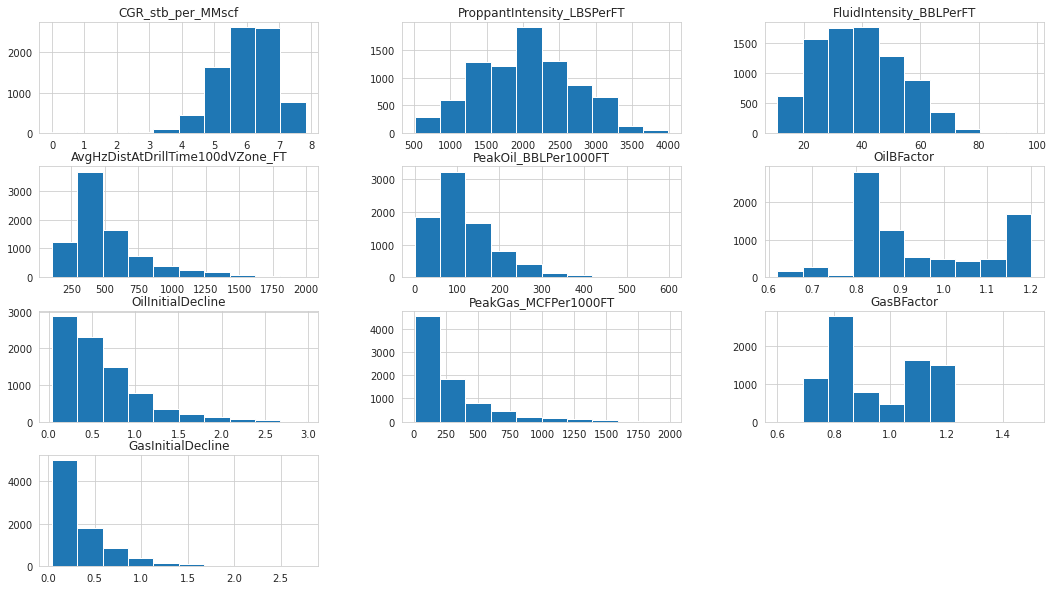

In [19]:
x = model_DF_One_Hot_Encoding.drop(dca_parameters, axis=1)
y = model_DF_One_Hot_Encoding[dca_parameters]

#separate train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.80, random_state=1)

x_train.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

model_DF_One_Hot_Encoding.hist(figsize=(18,10))
plt.show()

# 1. Linear Regression

Consideraciones:
- **Si se va a usar un modelo de regresión con fines puramente predictivos, es mejor en muchos casos utilizar otros modelos (como decision trees)**.
- Es importante primero verificar la correlación de las variables explicativas a utilizar en la regresion lineal (multicolinealidad, explicado mas abajo).
- Si bien es un modelo simple, requiere validación estadística para no obtener conclusiones equivocadas.
- **Onehot encoding: Produce columnas linealmente dependientes que es muy problemático en un modelo de regresión lineal. Si bien utilizar onehot encoding es correcto, es necesario eliminar columnas redundantes.**

Las siguientes celdas comprueban que tanto las columnas de area como la de parent-child, siempre suman 1, es decir:  
    - Sabiendo el valor de 2 columnas de area se deduce el valor de la tercera  
    - Sabiendo el valor de la columna Parent se deduce tambien el de la columna Child  
    
Por lo tanto, para utilizar estas columnas en una regresión lineal, se debería eliminar una de las de area y una de las de parent-child. Los parametros asociados a estas columnas mostrarían el incremento que tienen estas categorías por sobre la base.  Por ejemplo, si se elimina la columna Parent_Child_Parent, el parametro asociado a la columna Parent_Child_Child, representa el incremento que tienen las observaciones "Child" por sobre la categoría base que es "Parent".  


In [20]:
model_DF_One_Hot_Encoding[["Area_Central", "Area_East", "Area_West"]].apply(lambda x: x.sum(), axis=1).sum()

8261

In [21]:
model_DF_One_Hot_Encoding[["Parent_Child_Child", "Parent_Child_Parent"]].apply(lambda x: x.sum(), axis=1).sum()

8261

In [22]:
len(model_DF_One_Hot_Encoding)

8261

Se eliminan las columnas "Area_Central" y "Parent_Child_Child", por tanto, los parametros asociados a:
- Las variables de East y West representan el incremento en relacion al valor base que es Central
- La variable Parent_Child_Parent representa el incremento en relación al valor base que es Child

In [23]:
x_train = x_train.drop(columns=["Area_Central", "Parent_Child_Child"])
x_test = x_test.drop(columns=["Area_Central", "Parent_Child_Child"])

In [24]:
x_train_num = x_train.iloc[:,0:4]
x_train_bin = x_train.iloc[:,4:]

x_test_num = x_test.iloc[:,0:4]
x_test_bin = x_test.iloc[:,4:]

In [25]:
# Standardize dataset

# Use fit_transform in the numerical training data
scaler = StandardScaler()
x_train_num_s = scaler.fit_transform(x_train_num)
# DO NOT use fit in the test data, only transform
x_test_num_s = scaler.transform(x_test_num)

# add variables names
x_train_num_s = pd.DataFrame(x_train_num_s, columns=x_train_num.columns)
x_test_num_s = pd.DataFrame(x_test_num_s, columns=x_test_num.columns)

# Join scaled variables and binary variables
# (the + 0 is used to transform the boolean column to numerical)
x_train_s = pd.concat([x_train_num_s, x_train_bin], axis=1) + 0
x_test_s = pd.concat([x_test_num_s, x_test_bin], axis=1) + 0

In [26]:
x_train_s

,CGR_stb_per_MMscf,ProppantIntensity_LBSPerFT,FluidIntensity_BBLPerFT,AvgHzDistAtDrillTime100dVZone_FT,Area_East,Area_West,Parent_Child_Parent
0,0.607035,-0.640948,-0.573440,-0.518941,0,1,1
1,-1.411403,-1.242764,-1.204930,0.377022,1,0,0
2,-1.126476,-0.665141,0.268547,-0.639745,0,1,1
3,-1.620055,-0.045180,-0.012115,-0.515586,0,0,0
4,0.527967,1.421559,1.321031,-0.871286,1,0,0
...,...,...,...,...,...,...,...
6603,0.073492,1.858557,1.040368,-0.398137,1,0,1
6604,0.463116,-0.167660,-0.082281,-0.545787,0,1,0
6605,0.174266,-1.100627,-1.485593,-0.049148,0,1,1
6606,0.953371,0.952808,1.671859,-0.572632,0,0,0


In [27]:
x_test_s

,CGR_stb_per_MMscf,ProppantIntensity_LBSPerFT,FluidIntensity_BBLPerFT,AvgHzDistAtDrillTime100dVZone_FT,Area_East,Area_West,Parent_Child_Parent
0,0.019782,0.074277,-0.643606,1.017955,0,1,1
1,0.491167,-0.063325,0.479044,-0.784039,1,0,1
2,-1.481490,0.618633,0.970203,-0.310890,1,0,1
3,0.097809,-0.045180,0.408878,0.044811,0,1,1
4,-1.352427,-0.719577,-0.924268,0.232728,1,0,1
...,...,...,...,...,...,...,...
1648,-1.271893,1.107042,2.443680,-0.169952,1,0,0
1649,-0.542417,1.504725,0.338712,-0.643101,1,0,1
1650,-0.386861,0.685166,1.601693,0.158904,0,1,1
1651,-0.714801,0.007744,0.759706,0.215950,0,1,1


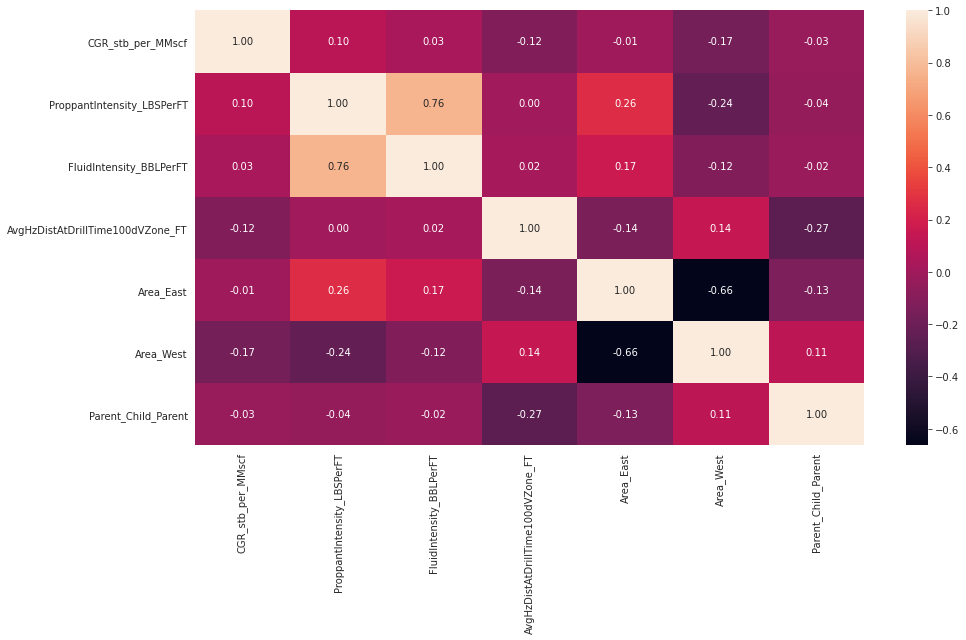

In [28]:
plt.figure(figsize=(15,8))
sns.heatmap(x_train_s.corr(),annot=True,fmt=".2f")
plt.show()

**Detección de multicolinealidad**

https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/  
https://etav.github.io/python/vif_factor_python.html   

La multicolinealidad basicamente es la problematica que se produce cuando hay variables muy correlacionadas lo que ocasiona que sea dificil aislar e identificar el efecto que tiene cada variable en la variable dependiente. Esto se puede cuantificar con el Variance Inflate Factor.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

In [30]:
# VIF dataframe 
vif_data = pd.DataFrame() 
  
X = add_constant(x_train_s)

vif_data["feature"] = X.columns 

# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 

vif_data

,feature,VIF
0,const,7.200493
1,CGR_stb_per_MMscf,1.086670
2,ProppantIntensity_LBSPerFT,2.544916
3,FluidIntensity_BBLPerFT,2.400184
4,AvgHzDistAtDrillTime100dVZone_FT,1.142664
5,Area_East,1.917902
6,Area_West,1.916252
7,Parent_Child_Parent,1.120178


Usualmente se considera que un VIF sobre 5 es una variable que genera este problema. Por tanto, en este caso no habría esta problemática. Se verifica también en la matriz de correlación donde no hay valores muy altos o muy bajos.

**Modelos y validaciòn**

Se debe evaluar cada modelo para cada variable de salida, hacer la validación correspondiente, obtener parametros significativos, revisar el ajuste del modelo y analizar su impacto en la variable de salida.

Para obtener conclusiones correctas (a través de inferencia estadistica) se debe validar el modelo. Esto es, verificar que se cumplen los supuestos:
- Linealidad entre variables explicativas y la variable dependiente
- Errores distribuidos de forma normal
- Errores independientes
- Homoscedasticidad (varianza de los residuos constante)  
  
https://www.kaggle.com/code/tawfikelmetwally/assumptions-of-linear-regression-model

Para analizar los resultados del modelo de regresion:
- Verificar siempre el F-statistic para determinar si el modelo de regresion con variables independientes es mejor que el modelo base. Si el F-statistic no es significativo, el modelo NO debe ser considerado.  
http://facweb.cs.depaul.edu/sjost/csc423/documents/f-test-reg.htm  
- Verificar lo p-values de cada parametro y seleccionar aquellos (significativos) que tienen valor menor a 0.05. Equivalentemente se verifica si lintervalo de confianza de los parametros incluye al 0.
- Analizar el coeficiente de determinación (más cercano a 1 es mejor).

*Explicacion de los valores p y los coeficientes de la regresion:  
https://www.w3schools.com/datascience/ds_linear_regression_pvalue.asp#:~:text=The%20P%2Dvalue&text=A%20low%20P%2Dvalue%20(%3C,called%20an%20insignificant%20P%2Dvalue.

https://quantifyinghealth.com/f-statistic-in-linear-regression/


In [31]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

MODEL 1


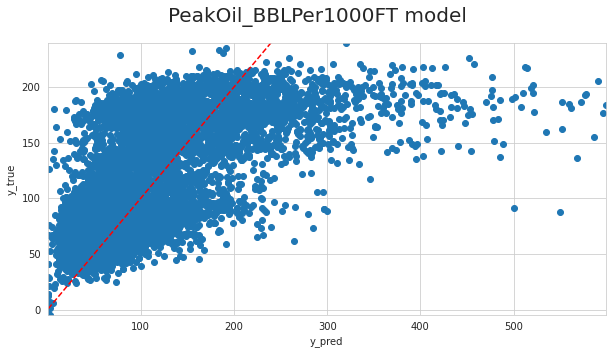

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


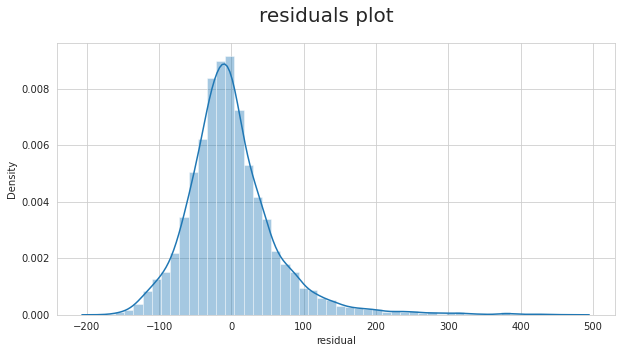

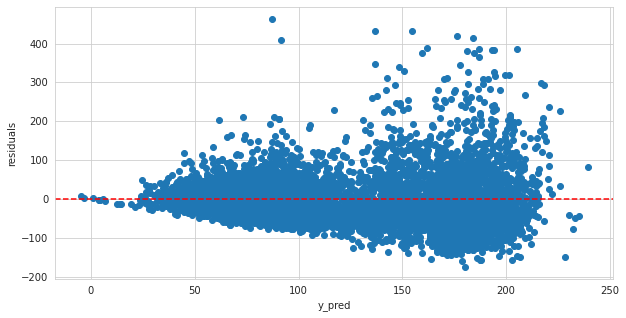

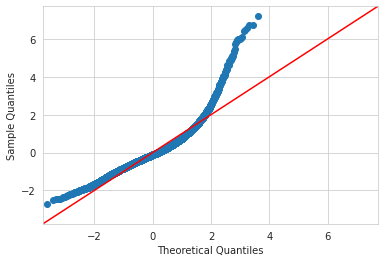

                             OLS Regression Results                             
Dep. Variable:     PeakOil_BBLPer1000FT   R-squared:                       0.374
Model:                              OLS   Adj. R-squared:                  0.374
Method:                   Least Squares   F-statistic:                     564.4
Date:                  Fri, 01 Mar 2024   Prob (F-statistic):               0.00
Time:                          09:16:28   Log-Likelihood:                -36858.
No. Observations:                  6608   AIC:                         7.373e+04
Df Residuals:                      6600   BIC:                         7.379e+04
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

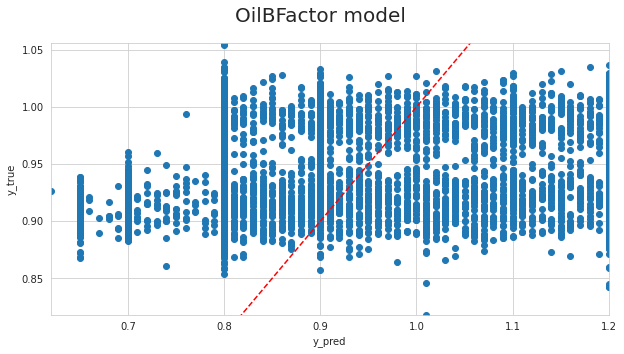

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


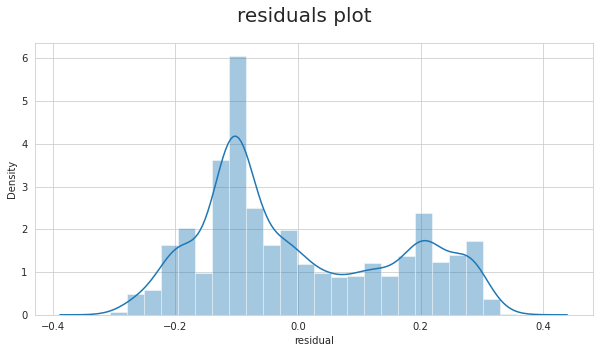

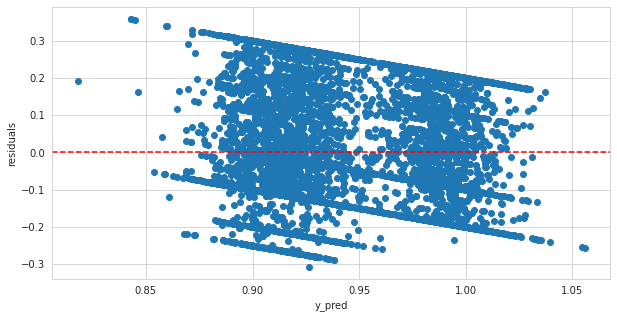

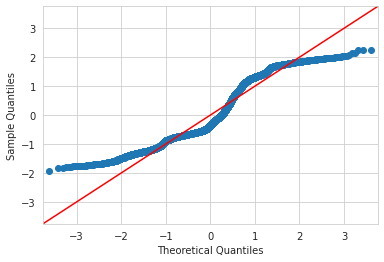

                            OLS Regression Results                            
Dep. Variable:             OilBFactor   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     58.11
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           3.00e-81
Time:                        09:16:30   Log-Likelihood:                 2806.4
No. Observations:                6608   AIC:                            -5597.
Df Residuals:                    6600   BIC:                            -5542.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

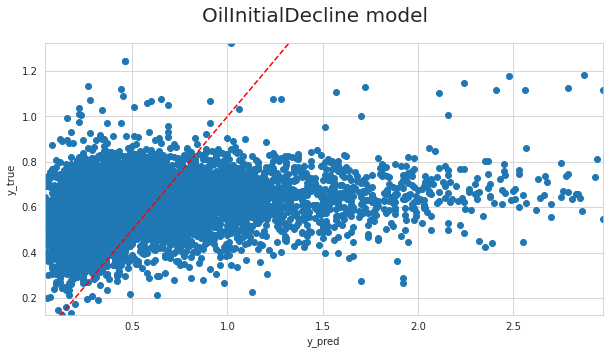

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


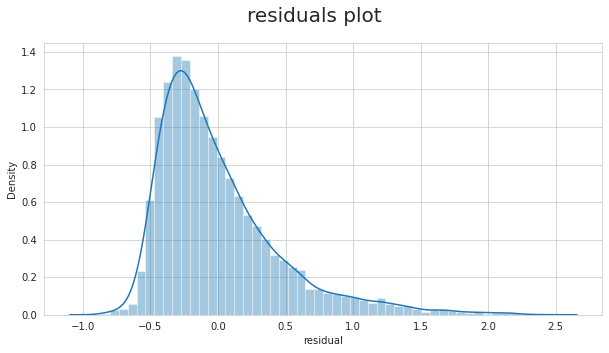

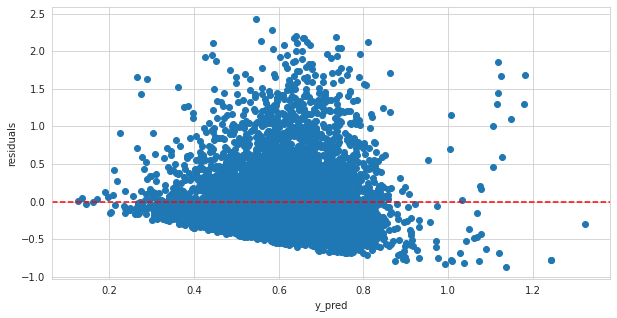

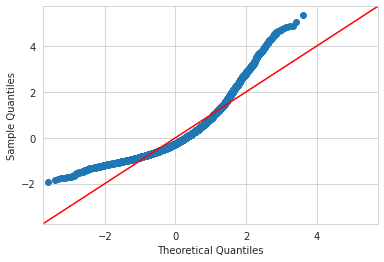

                            OLS Regression Results                            
Dep. Variable:      OilInitialDecline   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     66.26
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           9.82e-93
Time:                        09:16:31   Log-Likelihood:                -4118.6
No. Observations:                6608   AIC:                             8253.
Df Residuals:                    6600   BIC:                             8308.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

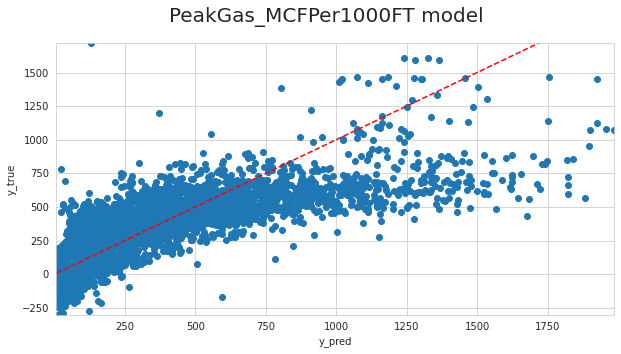

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


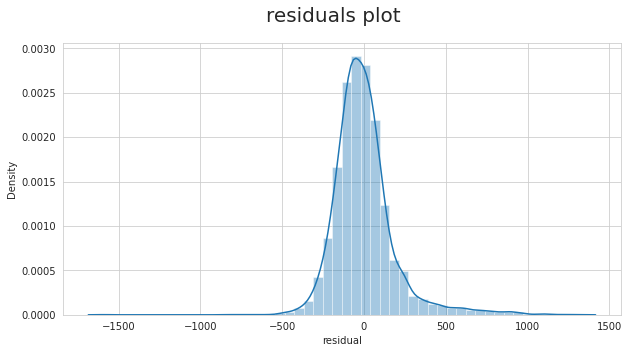

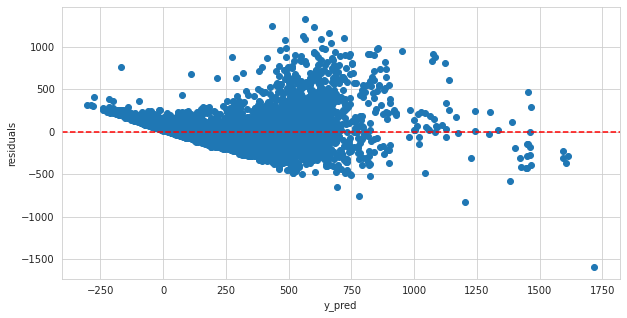

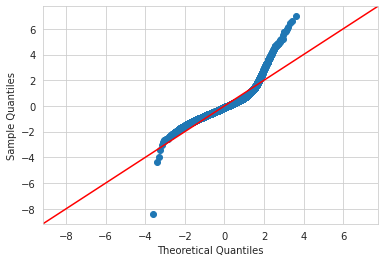

                             OLS Regression Results                             
Dep. Variable:     PeakGas_MCFPer1000FT   R-squared:                       0.602
Model:                              OLS   Adj. R-squared:                  0.602
Method:                   Least Squares   F-statistic:                     1426.
Date:                  Fri, 01 Mar 2024   Prob (F-statistic):               0.00
Time:                          09:16:32   Log-Likelihood:                -44008.
No. Observations:                  6608   AIC:                         8.803e+04
Df Residuals:                      6600   BIC:                         8.809e+04
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

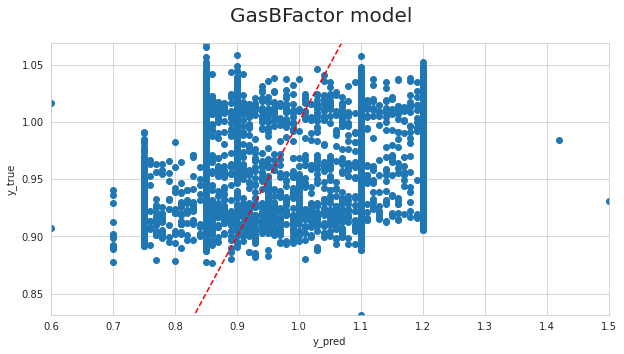

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


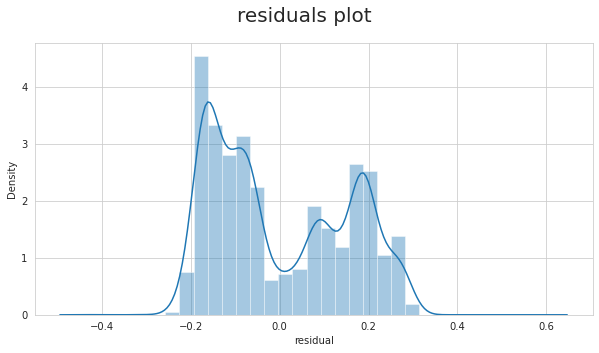

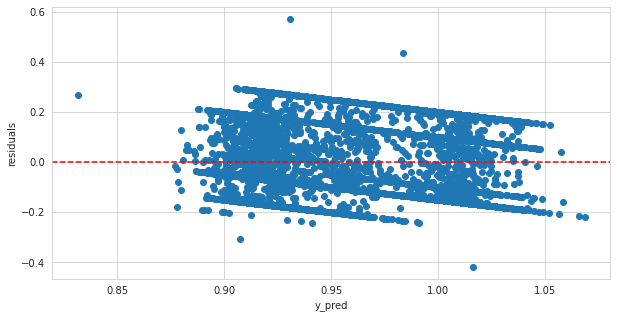

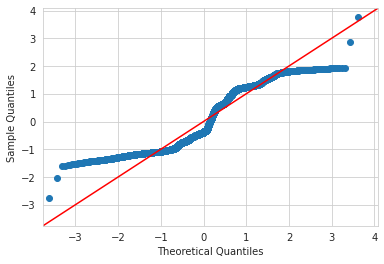

                            OLS Regression Results                            
Dep. Variable:             GasBFactor   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     73.49
Date:                Fri, 01 Mar 2024   Prob (F-statistic):          7.29e-103
Time:                        09:16:34   Log-Likelihood:                 3087.1
No. Observations:                6608   AIC:                            -6158.
Df Residuals:                    6600   BIC:                            -6104.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

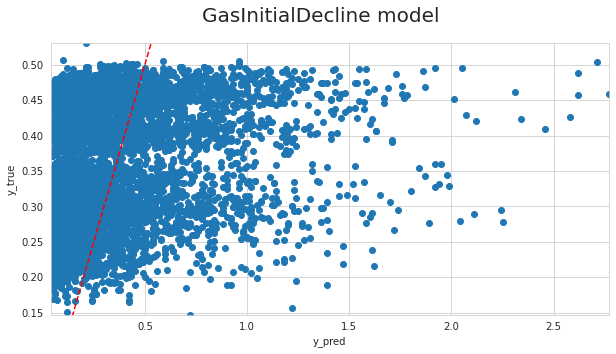

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


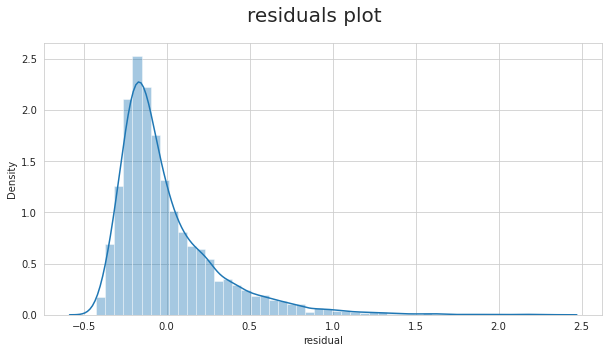

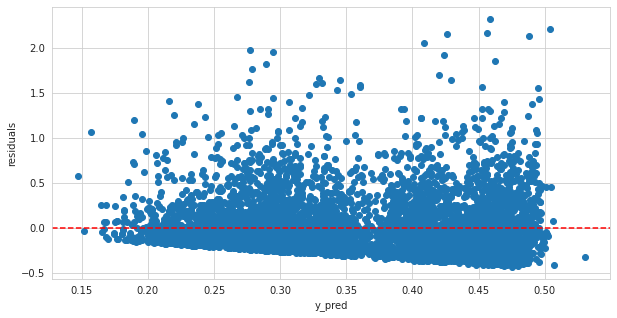

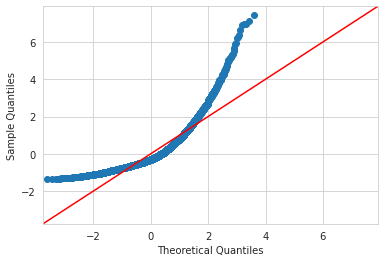

                            OLS Regression Results                            
Dep. Variable:      GasInitialDecline   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     70.25
Date:                Fri, 01 Mar 2024   Prob (F-statistic):           2.45e-98
Time:                        09:16:35   Log-Likelihood:                -1626.0
No. Observations:                6608   AIC:                             3268.
Df Residuals:                    6600   BIC:                             3322.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.374,0.379,46.041468,67.006888
1,OilBFactor,0.058,0.055,0.136534,0.158755
2,OilInitialDecline,0.066,0.063,0.333292,0.440191
3,PeakGas_MCFPer1000FT,0.602,0.617,130.394658,187.477482
4,GasBFactor,0.072,0.068,0.137803,0.151198
5,GasInitialDecline,0.069,0.043,0.216868,0.304178


In [32]:
train_scores = []
test_scores = []
mae_test_scores = []
rmse_test_scores = []

for i, col in enumerate(y_train.columns.tolist()):
    
    print(f"MODEL {i+1}")
    #fit linear regression
    lr = LinearRegression()
    lr.fit(x_train_s, y_train.loc[:,col])

    #test accuracy of the linear regression
    test_score_col = lr.score(x_test_s,y_test.loc[:,col]).round(3)
    test_scores.append(test_score_col)
    
    train_score_col = lr.score(x_train_s,y_train.loc[:,col]).round(3)
    train_scores.append(train_score_col)
    
    y_pred = lr.predict(x_train_s)
    residuals = y_train.loc[:,col].values - y_pred
    
    # use statsmodel library instead to get p values and parameters estimates
    X2 = sm.add_constant(x_train_s)
    #X2 = x_train_s
    est = sm.OLS(y_train.loc[:,col], X2)
    est2 = est.fit()
    
    # Plot 1: pred vs true
    fig = plt.figure(figsize=(10,5))
    plt.scatter(y_train.loc[:,col].values, y_pred)
    x_1 = np.min([y_pred.min(), y_train.loc[:,col].min()])
    x_2 = np.max([y_pred.max(), y_train.loc[:,col].max()])      
    plt.plot([x_1, x_2],
             [x_1, x_2],
             linestyle='dashed',color='red')
    fig.suptitle(f'{col} model', fontsize = 20)    
    plt.xlabel('y_pred')
    plt.ylabel('y_true')
    plt.xlim(y_train.loc[:,col].min(), y_train.loc[:,col].max())
    plt.ylim(y_pred.min(), y_pred.max())
    plt.show()    
    # plot 2: residuals hist
    fig = plt.figure(figsize=(10,5))
    sns.distplot(residuals)
    fig.suptitle(f'residuals plot', fontsize = 20)    
    plt.xlabel('residual')
    plt.show()
    # plot 3: y_pred vs residuals
    fig = plt.figure(figsize=(10,5))
    plt.scatter(y_pred , residuals)
    plt.xlabel('y_pred')
    plt.ylabel('residuals')
    plt.axhline(y=0,color="red" ,linestyle="--")
    plt.show()
    # plot 4: qq plot
    fig = sm.qqplot(residuals,fit=True, line='45')
    plt.show()
    
    # Performance / metrics
    print(est2.summary())
    y_pred_test = lr.predict(x_test_s)
    mae = mean_absolute_error(y_test.loc[:,col].values, y_pred_test)
    rmse = mean_squared_error(y_test.loc[:,col].values, y_pred_test)**(1/2)
    mae_test_scores.append(mae)
    rmse_test_scores.append(rmse)
    
    print('train dataset R2 score: \t' + str(lr.score(x_train_s,y_train.loc[:,col]).round(3)))
    print('test dataset R2 score: \t\t' + str(lr.score(x_test_s,y_test.loc[:,col]).round(3)))
    print('test dataset MAE score: \t' + str(mae.round(3)))
    print('test dataset RMSE score: \t' + str(rmse.round(3)))
    print("\n")


full_lr_results = pd.DataFrame({"variable" : y_train.columns.tolist(),
                            "train_score" : train_scores, 
                            "test_score" : test_scores,
                            "mae_test" : mae_test_scores,
                            "rmse_test" : rmse_test_scores})

full_lr_results

Ejemplo resultados: Modelo de la variable de salida 
**PeakGas_MCPer1000FT**

- Idealmente se tiene que checkear estadisticamente la normalidad de los residuos,
    que no estén correlacionados, homoscedasticidad, etc.. pero a simple vista no presenta problemas drásticos salvo una parte de la muestra con errores muy grandes que afectan la curva qq plot  
- El F-statistic es significativo, lo que implica que el modelo es superior a un modelo sin variables independientes  
- El R2 es aceptable 0.602. Además, el test set tiene un R2 de 0.617 por lo que el modelo esta ajustado de forma correcta  
- Tiene todos los parametros significativos a excepcion de ProppantIntensity_LBSPerFT que no es significativo, por tanto, no existe evidencia suficiente para rechazar que este parametro es igual a 0 (es decir, no se puede concluir que esta variable afecta al PeakGas_MCPer1000FT).


**Parametros e Interpretación**:  


- constante:                              264.8236  

Variables Numéricas:  

- CGR_stb_per_MMscf:                 -203.7892 
- FluidIntensity_BBLPerFT:             26.8511  
- AvgHzDistAtDrillTime100dVZone_FT:    13.6765 

Cuando no se escala las variables independientes, la interpretación de los parametros es evidente, esto es, "cuanto afecta en promedio el incremento de una unidad de la variable sobre la variable dependiente". Sin embargo, si bien estos parametros son informativos, no son comparables, ya que dependen de las unidades de las variables.

La alternativa es estandarizar las variables (media 0 y desviaciòn standard 1) y de esta forma, los parametros cuantifican el impacto que tiene una variable en la variable dependiente.

*Standardized coefficient:  
https://en.wikipedia.org/wiki/Standardized_coefficient#:%7E:text=In%20statistics%2C%20standardized%20%5Bregression%5D,and%20independent%20variables%20are%201.  

https://u.demog.berkeley.edu/~andrew/teaching/standard_coeff.pdf   

Variables Categoricas:  
- Area_East:                           134.9243  
Las observaciones en area East tienden a tener un incremento de 134.9243 unidades en el PeakGas_MCPer1000FT, por sobre la categoría base que es Central  
- Area_West:                        -147.4868   
Las observaciones en area West tienden a tener un decrecimiento de 147.4868 unidades en el PeakGas_MCPer1000FT, por sobre la categoría base que es Central  

- Parent_Child_Parent:                 25.7400   
 Las observaciones Parent tienden a tener un incremento de 25.7400, por sobre la categoría base que es Child  

# 2. Linear Regression with Regularization

**2.1 Lasso Regression**  

"LASSO is useful in some contexts due to its tendency to prefer solutions with fewer parameter values, effectively reducing the number of variables upon which the given solution is dependent. For this reason, the LASSO and its variants are fundamental to the field of compressed sensing."

Lasso es un modelo de regresión que minimiza no solo el error en las predicciones si no tambien la complejidad del modelo.

https://tahera-firdose.medium.com/lasso-regression-a-comprehensive-guide-to-feature-selection-and-regularization-2c6a20b61e23  

https://www.datacamp.com/tutorial/tutorial-lasso-ridge-regression   

In [33]:
x_train_num

,CGR_stb_per_MMscf,ProppantIntensity_LBSPerFT,FluidIntensity_BBLPerFT,AvgHzDistAtDrillTime100dVZone_FT
0,6.511667,1608.0,31.0,365.0
1,4.624761,1210.0,22.0,632.0
2,4.891120,1592.0,43.0,329.0
3,4.429705,2002.0,39.0,366.0
4,6.437752,2972.0,58.0,260.0
...,...,...,...,...
6603,6.012892,3261.0,54.0,401.0
6604,6.377127,1921.0,38.0,357.0
6605,6.107100,1304.0,18.0,505.0
6606,6.835435,2662.0,63.0,349.0


In [34]:
x_train_bin

,Area_East,Area_West,Parent_Child_Parent
0,False,True,True
1,True,False,False
2,False,True,True
3,False,False,False
4,True,False,False
...,...,...,...
6603,True,False,True
6604,False,True,False
6605,False,True,True
6606,False,False,False


In [35]:
from sklearn.preprocessing import PolynomialFeatures

In [36]:
# Define polynomial degree to be used in Lasso and Ridge
degree_polynomial = 1

In [37]:
# Obtain polynomial features
poly = PolynomialFeatures(degree=degree_polynomial, include_bias=False)
x_train_num_poly = poly.fit_transform(x_train_num)
x_test_num_poly = poly.fit_transform(x_test_num)

# scale polynomial features
poly_scaler = StandardScaler()
x_train_num_poly_scaled = poly_scaler.fit_transform(x_train_num_poly)
x_test_num_poly_scaled = poly_scaler.transform(x_test_num_poly)

# add variables names
x_train_num_s = pd.DataFrame(x_train_num_poly_scaled, columns=poly.get_feature_names(x_train_num.columns))
x_test_num_s = pd.DataFrame(x_test_num_poly_scaled, columns=poly.get_feature_names(x_test_num.columns))

# join poly scaled variables and binary variables
# (the + 0 is used to transform the boolean column to numerical)
x_train_s = pd.concat([x_train_num_s, x_train_bin], axis=1) + 0
x_test_s = pd.concat([x_test_num_s, x_test_bin], axis=1) + 0

In [38]:
from sklearn.linear_model import LassoCV

In [39]:
train_scores = []
test_scores = []
mae_test_scores = []
rmse_test_scores = []

for i, col in enumerate(y_train.columns.tolist()):
    print(f"Output Variable : {col} \n")
    
    model = LassoCV(eps=0.001, alphas=[alpha for alpha in np.arange(0.001, 10, 0.001)],
                    fit_intercept=True, normalize=False, precompute='auto', 
                    max_iter=1e8, tol=0.0001, copy_X=True, cv=4, verbose=False, n_jobs=8, 
                    positive=False, random_state=0)

    model.fit(x_train_s, y_train.loc[:,col].values) 
    y_pred_test = model.predict(x_test_s)
    
    mae = mean_absolute_error(y_test.loc[:,col].values, y_pred_test)
    rmse = mean_squared_error(y_test.loc[:,col].values, y_pred_test)**(1/2)
    train_score_col = model.score(x_train_s, y_train.loc[:,col].values).round(3)
    test_score_col  = model.score(x_test_s, y_test.loc[:,col].values).round(3)
    
    train_scores.append(train_score_col)
    test_scores.append(test_score_col)
    mae_test_scores.append(mae)
    rmse_test_scores.append(rmse)
    
    print('train dataset R2 score: \t' + str(model.score(x_train_s, y_train.loc[:,col].values).round(3)))
    print('test dataset R2 score: \t\t' + str(model.score(x_test_s, y_test.loc[:,col].values).round(3)))
    print('test dataset MAE score: \t' + str(mae.round(3)))
    print('test dataset RMSE score: \t' + str(rmse.round(3)))
    print("\n")
    
    print(f"alpha : {model.alpha_.round(3)} \n")
    
    lasso_results = pd.DataFrame({"variable" : x_train_s.columns, "coefficient" : model.coef_})
    lasso_results = lasso_results.sort_values("coefficient", ascending=False)
    
    print(lasso_results)
    print("\n")

full_lasso_results = pd.DataFrame(
    {
        "variable" : y_train.columns.tolist(),
        "train_score" : train_scores, 
        "test_score" : test_scores,
        "mae_test" : mae_test_scores,
        "rmse_test" : rmse_test_scores}
)

full_lasso_results

Output Variable : PeakOil_BBLPer1000FT 

train dataset R2 score: 	0.374
test dataset R2 score: 		0.379
test dataset MAE score: 	46.041
test dataset RMSE score: 	67.007


alpha : 0.001 

                           variable  coefficient
4                         Area_East    72.929639
1        ProppantIntensity_LBSPerFT    10.326856
0                 CGR_stb_per_MMscf     9.159966
2           FluidIntensity_BBLPerFT     8.480957
6               Parent_Child_Parent     6.721848
3  AvgHzDistAtDrillTime100dVZone_FT    -2.695137
5                         Area_West   -13.439606


Output Variable : OilBFactor 

train dataset R2 score: 	0.058
test dataset R2 score: 		0.054
test dataset MAE score: 	0.137
test dataset RMSE score: 	0.159


alpha : 0.001 

                           variable  coefficient
5                         Area_West     0.064247
0                 CGR_stb_per_MMscf     0.010791
3  AvgHzDistAtDrillTime100dVZone_FT     0.005941
1        ProppantIntensity_LBSPerFT    -0.000000
6

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.374,0.379,46.041396,67.006974
1,OilBFactor,0.058,0.054,0.136822,0.158812
2,OilInitialDecline,0.065,0.064,0.333083,0.440059
3,PeakGas_MCFPer1000FT,0.602,0.617,130.373466,187.473234
4,GasBFactor,0.072,0.068,0.138051,0.151194
5,GasInitialDecline,0.069,0.044,0.216860,0.303988


**2.2. Ridge Regression**

In [40]:
from sklearn.linear_model import RidgeCV

In [113]:
train_scores = []
test_scores = []
mae_test_scores = []
rmse_test_scores = []

for i, col in enumerate(y_train.columns.tolist()):
    print(f"Output Variable : {col} \n")
    
    model = RidgeCV(alphas=[alpha for alpha in np.arange(0.1, 100, 0.1)], fit_intercept=True, scoring=None,
                    cv=3, gcv_mode='auto', store_cv_values=False, alpha_per_target=False)

    model.fit(x_train_s, y_train.loc[:,col].values) 
    y_pred_test = model.predict(x_test_s)
    
    mae = mean_absolute_error(y_test.loc[:,col].values, y_pred_test)
    rmse = mean_squared_error(y_test.loc[:,col].values, y_pred_test)**(1/2)
    train_score_col = model.score(x_train_s, y_train.loc[:,col].values).round(3)
    test_score_col  = model.score(x_test_s, y_test.loc[:,col].values).round(3)
    
    train_scores.append(train_score_col)
    test_scores.append(test_score_col)
    mae_test_scores.append(mae)
    rmse_test_scores.append(rmse)
    
    print('train dataset R2 score: \t' + str(model.score(x_train_s, y_train.loc[:,col].values).round(3)))
    print('test dataset R2 score: \t\t' + str(model.score(x_test_s, y_test.loc[:,col].values).round(3)))
    print('test dataset MAE score: \t' + str(mae.round(3)))
    print('test dataset RMSE score: \t' + str(rmse.round(3)))
    print("\n")
    
    print(f"alpha : {model.alpha_.round(3)} \n")
    
    ridge_results = pd.DataFrame({"variable" : x_train_s.columns, "coefficient" : model.coef_})
    ridge_results = ridge_results.sort_values("coefficient", ascending=False)
    print(ridge_results)
    
    print("\n")

full_ridge_results = pd.DataFrame(
    {
        "variable" : y_train.columns.tolist(),
        "train_score" : train_scores, 
        "test_score" : test_scores,
        "mae_test" : mae_test_scores,
        "rmse_test" : rmse_test_scores}
)

Output Variable : PeakOil_BBLPer1000FT 

train dataset R2 score: 	0.399
test dataset R2 score: 		0.405
test dataset MAE score: 	45.14
test dataset RMSE score: 	65.638


alpha : 13.9 

                                             variable  coefficient
14                                          Area_East    65.109849
0                                   CGR_stb_per_MMscf    46.201846
9   ProppantIntensity_LBSPerFT FluidIntensity_BBLP...    28.133085
6           CGR_stb_per_MMscf FluidIntensity_BBLPerFT    21.851975
8                        ProppantIntensity_LBSPerFT^2    21.532946
16                                Parent_Child_Parent     7.180378
10  ProppantIntensity_LBSPerFT AvgHzDistAtDrillTim...     3.205556
3                    AvgHzDistAtDrillTime100dVZone_FT     2.962622
13                 AvgHzDistAtDrillTime100dVZone_FT^2     1.783733
2                             FluidIntensity_BBLPerFT     0.403050
7   CGR_stb_per_MMscf AvgHzDistAtDrillTime100dVZon...    -2.388982
5        CGR

In [114]:
full_ridge_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.399,0.405,45.139943,65.638319
1,OilBFactor,0.064,0.056,0.136689,0.158668
2,OilInitialDecline,0.070,0.069,0.332232,0.438962
3,PeakGas_MCFPer1000FT,0.616,0.632,127.402461,183.747624
4,GasBFactor,0.077,0.075,0.137178,0.150613
5,GasInitialDecline,0.074,0.046,0.216077,0.303678


# 3. Polynomial Regression

**Consejos on "How to use polynomial features":**  
- Generar interacciones y potencias  
- Escalar posteriormente  
- No utilizar dummy variables en interacciones  

https://samchaaa.medium.com/preprocessing-why-you-should-generate-polynomial-features-first-before-standardizing-892b4326a91d 

In [115]:
# Define polynomial degree to be used in Lasso and Ridge
degree_polynomial = 2

In [116]:
# Obtain polynomial features
poly = PolynomialFeatures(degree=degree_polynomial, include_bias=False)
x_train_num_poly = poly.fit_transform(x_train_num)
x_test_num_poly = poly.fit_transform(x_test_num)

# scale polynomial features
poly_scaler = StandardScaler()
x_train_num_poly_scaled = poly_scaler.fit_transform(x_train_num_poly)
x_test_num_poly_scaled = poly_scaler.transform(x_test_num_poly)

# add variables names
x_train_num_s = pd.DataFrame(x_train_num_poly_scaled, columns=poly.get_feature_names(x_train_num.columns))
x_test_num_s = pd.DataFrame(x_test_num_poly_scaled, columns=poly.get_feature_names(x_test_num.columns))

# join poly scaled variables and binary variables
# (the + 0 is used to transform the boolean column to numerical)
x_train_s = pd.concat([x_train_num_s, x_train_bin], axis=1) + 0
x_test_s = pd.concat([x_test_num_s, x_test_bin], axis=1) + 0

**3.1 Lasso with polynomial**

In [117]:
train_scores = []
test_scores = []
mae_test_scores = []
rmse_test_scores = []

for i, col in enumerate(y_train.columns.tolist()):
    print(f"Output Variable : {col} \n")
    
    model = LassoCV(eps=0.001, n_alphas=1000, fit_intercept=True, normalize=False, precompute='auto', 
                    max_iter=1e8, tol=0.0001, copy_X=True, cv=4, verbose=False, n_jobs=8, 
                    positive=False, random_state=0)

    model.fit(x_train_s, y_train.loc[:,col].values) 
    y_pred_test = model.predict(x_test_s)
    
    mae = mean_absolute_error(y_test.loc[:,col].values, y_pred_test)
    rmse = mean_squared_error(y_test.loc[:,col].values, y_pred_test)**(1/2)
    train_score_col = model.score(x_train_s, y_train.loc[:,col].values).round(3)
    test_score_col  = model.score(x_test_s, y_test.loc[:,col].values).round(3)
    
    train_scores.append(train_score_col)
    test_scores.append(test_score_col)
    mae_test_scores.append(mae)
    rmse_test_scores.append(rmse)
    
    print('train dataset R2 score: \t' + str(model.score(x_train_s, y_train.loc[:,col].values).round(3)))
    print('test dataset R2 score: \t\t' + str(model.score(x_test_s, y_test.loc[:,col].values).round(3)))
    print('test dataset MAE score: \t' + str(mae.round(3)))
    print('test dataset RMSE score: \t' + str(rmse.round(3)))
    print("\n")
    
    print(f"alpha : {model.alpha_.round(3)} \n")
    
    lasso_poly_results = pd.DataFrame({"variable" : x_train_s.columns, "coefficient" : model.coef_})
    lasso_poly_results = lasso_poly_results.sort_values("coefficient", ascending=False)
    
    print(lasso_poly_results)
    print("\n")
    
full_lasso_poly_results = pd.DataFrame(
    {
        "variable" : y_train.columns.tolist(),
        "train_score" : train_scores, 
        "test_score" : test_scores,
        "mae_test" : mae_test_scores,
        "rmse_test" : rmse_test_scores}
)

Output Variable : PeakOil_BBLPer1000FT 

train dataset R2 score: 	0.399
test dataset R2 score: 		0.404
test dataset MAE score: 	45.146
test dataset RMSE score: 	65.644


alpha : 0.065 

                                             variable  coefficient
14                                          Area_East    65.620448
0                                   CGR_stb_per_MMscf    46.315756
9   ProppantIntensity_LBSPerFT FluidIntensity_BBLP...    27.995237
8                        ProppantIntensity_LBSPerFT^2    20.081114
6           CGR_stb_per_MMscf FluidIntensity_BBLPerFT    18.994298
16                                Parent_Child_Parent     6.955815
13                 AvgHzDistAtDrillTime100dVZone_FT^2     1.533542
3                    AvgHzDistAtDrillTime100dVZone_FT     0.664649
10  ProppantIntensity_LBSPerFT AvgHzDistAtDrillTim...     0.619867
7   CGR_stb_per_MMscf AvgHzDistAtDrillTime100dVZon...    -0.000000
2                             FluidIntensity_BBLPerFT     0.000000
5        C

In [118]:
full_lasso_poly_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.399,0.404,45.146476,65.644440
1,OilBFactor,0.064,0.056,0.136674,0.158668
2,OilInitialDecline,0.070,0.070,0.332091,0.438638
3,PeakGas_MCFPer1000FT,0.616,0.633,127.075933,183.658805
4,GasBFactor,0.077,0.075,0.137099,0.150643
5,GasInitialDecline,0.074,0.046,0.216115,0.303723


**3.2 Ridge with polynomial**

In [119]:
train_scores = []
test_scores = []
mae_test_scores = []
rmse_test_scores = []

for i, col in enumerate(y_train.columns.tolist()):
    print(f"Output Variable : {col} \n")
    
    model = RidgeCV(alphas=[alpha for alpha in range(0,100,1)], fit_intercept=True, scoring=None, cv=4,
                    gcv_mode='auto', store_cv_values=False, alpha_per_target=False)

    model.fit(x_train_s, y_train.loc[:,col].values) 
    y_pred_test = model.predict(x_test_s)
    
    mae = mean_absolute_error(y_test.loc[:,col].values, y_pred_test)
    rmse = mean_squared_error(y_test.loc[:,col].values, y_pred_test)**(1/2)
    train_score_col = model.score(x_train_s, y_train.loc[:,col].values).round(3)
    test_score_col  = model.score(x_test_s, y_test.loc[:,col].values).round(3)
    
    train_scores.append(train_score_col)
    test_scores.append(test_score_col)
    mae_test_scores.append(mae)
    rmse_test_scores.append(rmse)
    
    print('train dataset R2 score: \t' + str(model.score(x_train_s, y_train.loc[:,col].values).round(3)))
    print('test dataset R2 score: \t\t' + str(model.score(x_test_s, y_test.loc[:,col].values).round(3)))
    print('test dataset MAE score: \t' + str(mae.round(3)))
    print('test dataset RMSE score: \t' + str(rmse.round(3)))
    print("\n")
    
    print(f"alpha : {model.alpha_.round(3)} \n")
    
    ridge_poly_results = pd.DataFrame({"variable" : x_train_s.columns, "coefficient" : model.coef_})
    ridge_poly_results = ridge_poly_results.sort_values("coefficient", ascending=False)
    print(ridge_poly_results)
    
    print("\n")
    
full_ridge_poly_results = pd.DataFrame(
    {
        "variable" : y_train.columns.tolist(),
        "train_score" : train_scores, 
        "test_score" : test_scores,
        "mae_test" : mae_test_scores,
        "rmse_test" : rmse_test_scores}
)

Output Variable : PeakOil_BBLPer1000FT 

train dataset R2 score: 	0.399
test dataset R2 score: 		0.405
test dataset MAE score: 	45.143
test dataset RMSE score: 	65.629


alpha : 11 

                                             variable  coefficient
14                                          Area_East    65.215725
0                                   CGR_stb_per_MMscf    47.550183
9   ProppantIntensity_LBSPerFT FluidIntensity_BBLP...    29.343388
6           CGR_stb_per_MMscf FluidIntensity_BBLPerFT    21.877371
8                        ProppantIntensity_LBSPerFT^2    21.770325
16                                Parent_Child_Parent     7.232088
3                    AvgHzDistAtDrillTime100dVZone_FT     3.648218
10  ProppantIntensity_LBSPerFT AvgHzDistAtDrillTim...     3.377838
13                 AvgHzDistAtDrillTime100dVZone_FT^2     1.727413
2                             FluidIntensity_BBLPerFT     1.011921
7   CGR_stb_per_MMscf AvgHzDistAtDrillTime100dVZon...    -3.018498
5        CGR_

In [120]:
full_ridge_poly_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.399,0.405,45.142950,65.629194
1,OilBFactor,0.064,0.056,0.136690,0.158673
2,OilInitialDecline,0.071,0.071,0.332102,0.438415
3,PeakGas_MCFPer1000FT,0.616,0.632,127.434736,183.830631
4,GasBFactor,0.077,0.075,0.137131,0.150643
5,GasInitialDecline,0.074,0.046,0.216078,0.303694


# 4. Resumen y Conclusiones

A continuación se muestran los resultados y metricas de los modelos para cada variable dependiente

**Regresión Lineal**

In [121]:
full_lr_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.374,0.379,46.041468,67.006888
1,OilBFactor,0.058,0.055,0.136534,0.158755
2,OilInitialDecline,0.066,0.063,0.333292,0.440191
3,PeakGas_MCFPer1000FT,0.602,0.617,130.394658,187.477482
4,GasBFactor,0.072,0.068,0.137803,0.151198
5,GasInitialDecline,0.069,0.043,0.216868,0.304178


**Regresión lineal con regularización Lasso**

In [122]:
full_lasso_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.374,0.379,46.041396,67.006974
1,OilBFactor,0.058,0.054,0.136822,0.158812
2,OilInitialDecline,0.065,0.064,0.333083,0.440059
3,PeakGas_MCFPer1000FT,0.602,0.617,130.373466,187.473234
4,GasBFactor,0.072,0.068,0.138051,0.151194
5,GasInitialDecline,0.069,0.044,0.216860,0.303988


**Regresión lineal con regularización Ridge**

In [123]:
full_ridge_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.399,0.405,45.139943,65.638319
1,OilBFactor,0.064,0.056,0.136689,0.158668
2,OilInitialDecline,0.070,0.069,0.332232,0.438962
3,PeakGas_MCFPer1000FT,0.616,0.632,127.402461,183.747624
4,GasBFactor,0.077,0.075,0.137178,0.150613
5,GasInitialDecline,0.074,0.046,0.216077,0.303678


**Regresión polinomica grado 2 con regularización Lasso**

In [124]:
full_lasso_poly_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.399,0.404,45.146476,65.644440
1,OilBFactor,0.064,0.056,0.136674,0.158668
2,OilInitialDecline,0.070,0.070,0.332091,0.438638
3,PeakGas_MCFPer1000FT,0.616,0.633,127.075933,183.658805
4,GasBFactor,0.077,0.075,0.137099,0.150643
5,GasInitialDecline,0.074,0.046,0.216115,0.303723


**Regresión polinomica grado 2 con regularización Ridge**

In [125]:
full_ridge_poly_results

,variable,train_score,test_score,mae_test,rmse_test
0,PeakOil_BBLPer1000FT,0.399,0.405,45.142950,65.629194
1,OilBFactor,0.064,0.056,0.136690,0.158673
2,OilInitialDecline,0.071,0.071,0.332102,0.438415
3,PeakGas_MCFPer1000FT,0.616,0.632,127.434736,183.830631
4,GasBFactor,0.077,0.075,0.137131,0.150643
5,GasInitialDecline,0.074,0.046,0.216078,0.303694


Solo las variables **PeakOil_BBLPer1000FT** y **PeakGas_MCFPer1000FT** tienen un R2 aceptable. Por esta razón se analizan los resultados.

In [127]:
final_results = {}

for i, col in enumerate(['PeakOil_BBLPer1000FT', 'PeakGas_MCFPer1000FT']):
    
    df_scores = pd.DataFrame({'model' :['lr', 'lr_lasso', 'lr_ridge', 'poly_lasso', 'poly_ridge']})
    
    for j, metric in enumerate(full_lr_results.columns.tolist()[1:]):
        
        score_lr = full_lr_results[full_lr_results["variable"]==col][metric].values[0]
        score_lasso = full_lasso_results[full_lasso_results["variable"]==col][metric].values[0]
        score_ridge = full_ridge_results[full_ridge_results["variable"]==col][metric].values[0]
        score_lasso_poly = full_lasso_poly_results[full_lasso_poly_results["variable"]==col][metric].values[0]
        score_ridge_poly = full_ridge_poly_results[full_ridge_poly_results["variable"]==col][metric].values[0]
    
    
        df_iter = pd.DataFrame({ metric : [score_lr, score_lasso, score_ridge, score_lasso_poly,
                                           score_ridge_poly]})
                         
        df_scores = pd.concat([df_scores, df_iter], axis=1)
        final_results[col] = df_scores

In [128]:
final_results['PeakOil_BBLPer1000FT'].round(3).T

,0,1,2,3,4
model,lr,lr_lasso,lr_ridge,poly_lasso,poly_ridge
train_score,0.374,0.374,0.399,0.399,0.399
test_score,0.379,0.379,0.405,0.404,0.405
mae_test,46.041,46.041,45.14,45.146,45.143
rmse_test,67.007,67.007,65.638,65.644,65.629


In [129]:
final_results['PeakGas_MCFPer1000FT'].round(3).T

,0,1,2,3,4
model,lr,lr_lasso,lr_ridge,poly_lasso,poly_ridge
train_score,0.602,0.602,0.616,0.616,0.616
test_score,0.617,0.617,0.632,0.633,0.632
mae_test,130.395,130.373,127.402,127.076,127.435
rmse_test,187.477,187.473,183.748,183.659,183.831


Para ambas variables dependientes las metricas mejoran en regresiones polynomica de grado 2, sin embargo, esta mejora no es muy grande. Por esta razon, por parsimonia y por interpretabilidad, se escogen los modelos de tegresión lineal para ambas variables.

Se mencionó anteriormente que los modelos de árboles probablemente tienen mejores prestaciones predictivas que la regresión lineal. Lo interesante de la regresión lineal es la explicabilidad y el análisis de los parámetros estimados.  

A continuación se muestra un listado de los parametros significativos para cada una de estas dos variables. Recordar que las variables numéricas han sido estandarizadas, por tanto, los parametros para cada variable dan cuenta de la importancia que tiene cada una de ellas en la variable de salida (si no se hubiesen estandarizadas, los parametros son dependientes de la escala y las unidades de cada variable y por lo tanto, no son comparables entre ellos).

Modelo de **PeakOil_BBLPer1000FT**  
R2:  37%  

De las variables numéricas, se ve que que  las que más impactan en la variable de salida son:
- ProppantIntensity_LBSPerFT
- CGR_stb_per_MMscf
- FluidIntensity_BBLPerFT  

Además, se ve que, cuando las otras variables han sido controladas (equivalente a decir en igualdad de condiciones con respecto a las variables numericas):  
- El area East tiene un aumento promedio de 73 en la variable de salida por sobre el area Central  
- Las de Area West, tienen un decrecimiento promedio de 13 por sobre las de area Central  
- Las Parent tienen en promedio un aumento de 6 sobre las child

Modelo de **PeakGas_MCFPer1000FT**  
R2:  60%  

De las variables numéricas, se ve que que  las que más impactan en la variable de salida es **CGR_stb_per_MMscf**, casi 10 veces mas importante que la siguiente numérica que es **FluidIntensity_BBLPerFT**.

Además, se ve que, cuando las otras variables han sido controladas (equivalente a decir en igualdad de condiciones con respecto a las variables numericas):  
- El area East tiene un aumento promedio de 134 en la variable de salida por sobre el area Central  
- Las de Area West, tienen un decrecimiento promedio de 147 por sobre las de area Central 
- Las Parent tienen en promedio un aumento de 25 sobre las child

Para **PeakGas_MCFPer1000FT** resulta importante mencionar la presencia de observaciones que se desvian mucho de la predicción, ya que éstas podrían dar indicios de variables faltantes que ayuden a explicar/estimar mejor la variable de salida (este listado de observaciones se puede obtener facilmente).  

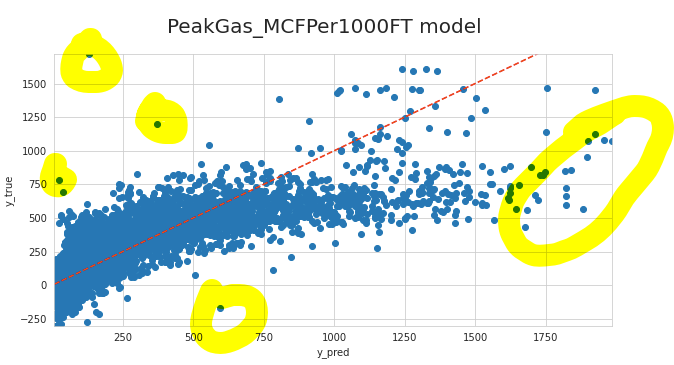